<a href="https://colab.research.google.com/github/stephyi/Twitter_User_Segmentation/blob/master/inluencers_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Import necessary modules

In [10]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

import matplotlib.dates as mdates
import seaborn as sns
#sns.set()

#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p


# to view all columns
pd.set_option("display.max.columns", None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')

## Analysis of the top 100 influencers

---



In [47]:
## reading the tweets from the csv file
influencers_tweets=pd.read_csv('influencers_tweets.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,8,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
influencers_tweets.head(5)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,0,1282761976343662593,Mon Jul 13 19:41:02 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",Actual video footage of me starting off the we...,Actual video footage starting week,"Sentiment(polarity=0.0, subjectivity=0.1)",0.00,0.1,en,20826.0,2748.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
1,1,1282073950843858944,Sat Jul 11 22:07:04 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @KingBach: https://t.co/Sj2sVP7Gdt,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.0,und,0.0,93038.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,KingBach,NaN,"New York, NY"
2,2,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.05,0.5,en,43410.0,6011.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
3,3,1280258784485572611,Mon Jul 06 21:54:14 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Me at the restaurant after things return to no...,Me restaurant things return normal,"Sentiment(polarity=0.15, subjectivity=0.649999...",0.15,0.6499999999999999,en,14700.0,1649.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY"
4,4,1276561514456113152,Fri Jun 26 17:02:37 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @franklinleonard: “I have rape-colored skin...,I rape-colored skin,"Sentiment(polarity=0.0, subjectivity=0.0)",0.00,0.0,en,0.0,408.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,franklinleonard,NaN,"New York, NY"


In [7]:
influencers_tweets.shape

(217977, 22)

In [8]:
#Dropping null values in the original_text column
influencers_tweets['clean_text'].dropna(inplace=True,how=all)
influencers_tweets['clean_text'].isnull().sum()


0

In [11]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

final_stopwords=stopwords.words('english')+ stopwords.words('french')

def tweet_tokenizer(verbatim):
    try:
        tokenizer = TweetTokenizer()
        all_tokens = tokenizer.tokenize(verbatim.lower())
        # this line filters out all tokens that are entirely non-alphabetic characters
        filtered_tokens = [t for t in all_tokens if t.islower()]
        # filter out all tokens that are <=2 chars
        filtered_tokens = [x for x in filtered_tokens if len(x)>2]
    except IndexError:
        filtered_tokens = []
    return(filtered_tokens)


# get the most common words in Tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_frequent_terms(text_series, stop_words = None, ngram_range = (1,2)):
    '''
    Input:
       text_series: a list or series of documents
       stop_words: a list of stop_words to ignore, or the string 'english',
                   which uses a built-in stop word list for the english language.
                   By default, there are no stop words used
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    the default (1,2) counts 1- and 2- grams.
    Returns:
       a dataframe of counts, indexed by n-gram
    '''
    count_vectorizer = CountVectorizer(analyzer = "word",
                                       tokenizer = tweet_tokenizer,
                                       stop_words = stop_words, # try changing the stopword sets that we use.
                                                                # notice that many top terms are words like
                                                                # "and" and "the"
                                       ngram_range = ngram_range # you can change this to count frequencies of
                                                           # ngrams as well as single tokens
                                                           # a range of (1,2) counts 1-grams (single tokens) and
                                                           # 2-grams (2-token phrases)
                                      )
    term_freq_matrix = count_vectorizer.fit_transform(text_series)
    terms = count_vectorizer.get_feature_names()
    term_frequencies = term_freq_matrix.sum(axis = 0).tolist()[0]

    term_freq_df = (pd.DataFrame(list(zip(terms, term_frequencies)), columns = ["token","count"])
                    .set_index("token")
                    .sort_values("count",ascending = False))
    return term_freq_df

In [12]:
term_freq_df = get_frequent_terms(influencers_tweets["clean_text"],
                                  stop_words =final_stopwords ) # stop_words = "english" removes words like 'and'

In [13]:
term_freq_df.head(30)

,count
token,
amp,12822
africa,9593
new,8775
one,6499
african,5715
south,5656
today,5619
n't,5557
people,5490


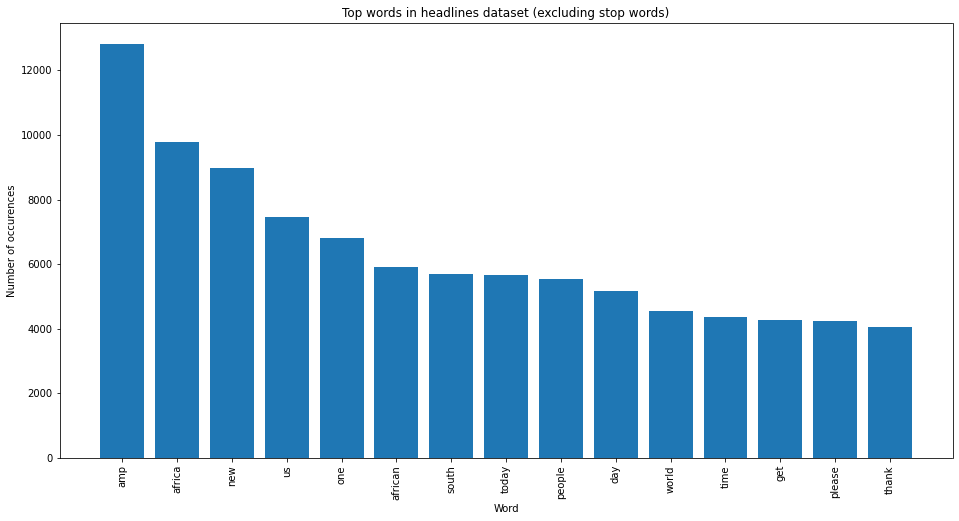

In [15]:
import gensim
import gensim.corpora as corpora
import numpy as np

data=influencers_tweets.clean_text.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# NLTK Stop words

stop_words = final_stopwords
stop_words.extend(['nan'])

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values.astype('U'))
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])



count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=influencers_tweets.clean_text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

[('Thank', 181), ('And different kind cool Introducing new Mercedes-Benz A-Class Sedan available', 93), ('A gift says thousand words new Mercedes-Benz A-Class Sedan', 89), ('End Day', 84), ('A regularly updated interactive map showing details spread around', 82), ("You 're welcome", 79), ('Thanks', 68), ('Indeed', 62), ('GAUTENG COVID-19 SUB-DISTRICT BREAKDOWNThe total number COVID-19 cases Gauteng', 59), ('Thank alerting us notified ^LM', 57)]


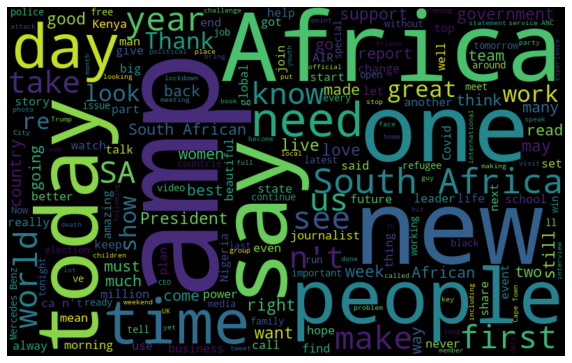

In [16]:
from collections import Counter
from wordcloud import WordCloud
##Analyzing highest occuring words term frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_features=1000,stop_words=final_stopwords)
tfidf=tfidf_vectorizer.fit_transform(influencers_tweets['clean_text'])

##Count most common frequent words
Counter=Counter(influencers_tweets['clean_text'])
most_occur=Counter.most_common(10)
print(most_occur)

##Visualization on word cloud
all_words=''.join([text for text in influencers_tweets['clean_text']])
wordcloud=WordCloud(width=800,height=500,max_font_size=200).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Visualizing the description of the users 

In [112]:
def clean_tweets(text):

        #use pre processor
        tweet = p.clean(text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        stop=stopwords.words('english')
        stop.extend(['South Africa','account','Twitter'])
        
        stop_words = set(stop)
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_text = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words  and w not in string.punctuation:
                filtered_text.append(w)

        return ' '.join(filtered_text)     
  

In [120]:
clean_description=[]
for description in influencers_tweets['description']:
  for single_description in str(description):
    filtered_description=clean_tweets(str(single_description))
    clean_description.append(filtered_description)

[('Writer Rewriter Foreign correspondent', 3246), ("TechCentral South Africa 's premier technology news website podcast network", 3245), ("South Africa 's premier online news resource Follow action journalists SA 's trusted news source Reuters Institute", 3238), ('Africa Research Institute non-partisan think tank based London We aim reflect understand build dynamism Africa today.RTendorsement', 3236), ('I curate digital media connect African-Americans The Diaspora The World new image The Continent', 3229), ('Je suis Marxiste tendance Groucho', 3228), ('Welcome official home South Africa Emergency Roadside Assistance:0800 SA', 3223), ('The official Cricket South Africa profile CSA custodians cricket South Africa', 3221), ('time Emmy nominated stand comedian South Africa info.com', 3218), ('The global business school Africa international triple-accredited MBA Africa customised education FT', 3218)]


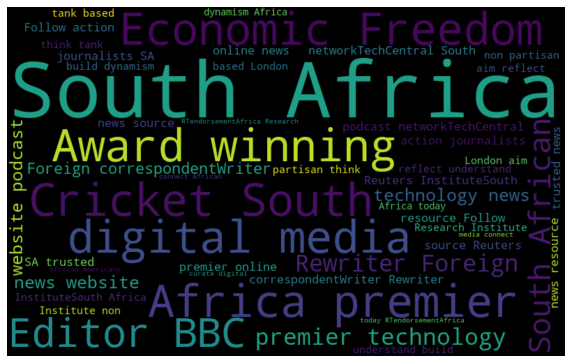

In [114]:
from collections import Counter
from wordcloud import WordCloud
##Analyzing highest occuring words term frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_features=1000,stop_words=final_stopwords)
tfidf=tfidf_vectorizer.fit_transform(clean_description)

##Count most common frequent words
Counter=Counter(clean_description)
most_occur=Counter.most_common(10)
print(most_occur)

##Visualization on word cloud
all_words=''.join([text for text in clean_description])
wordcloud=WordCloud(width=800,height=500,max_font_size=200,max_words=50).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
##Getting the maximum retweet_count for the users
retweets=(influencers_tweets[["original_author","retweet_count","hashtags"]]
    .sort_values("retweet_count",ascending = False)
    .groupby("original_author")
    .agg({"retweet_count":"max",'hashtags':'first'})
    
).head(15)

In [21]:
retweets[10:20]

,retweet_count,hashtags
original_author,,
AfricaResearch,5728.0,"Togo, Africa"
Aynte,106437.0,FridaysForFuture
BBCAndrewH,0.0,myfirstTweet
BobSkinstad,415537.0,JohnBercow
Camfed,16909.0,EarthDay


In [22]:
##Checking if there are users who talk about sports
influencers_tweets['contains_sports']=pd.Series(influencers_tweets['clean_text']).str.contains('sport') & pd.Series(influencers_tweets['clean_text']).str.contains('fitness')& pd.Series(influencers_tweets['clean_text']).str.contains('fit')
influencers_tweets[(influencers_tweets['contains_sports']==True)]['original_author'].unique()

array(['helenzille', 'equal_education'], dtype=object)

In [23]:
from collections import Counter

print("Most mentioned Twitter users:")
for item, count in Counter(influencers_tweets['user_mentions']).most_common(10):
    print(str(item) + "\t" + str(count))

print('----------------------------------------')
   
print("Most used hashtags:")
for item, count in Counter(influencers_tweets['hashtags']).most_common(10):
    print(str(item) + "\t" + str(count))

print('----------------------------------------')
print("Top 10 retweets:")

for item, count in Counter(influencers_tweets['retweet_count']).most_common(10):
      print(str(item) + "\t" + str(count))
     

Most mentioned Twitter users:
nan	88612
AUC_MoussaFaki	818
UlrichJvV	608
IFC_org	466
AJENews	422
EFFSouthAfrica	343
AJEnglish	317
CliffCentralCom	317
AdvoBarryRoux	308
DrZweliMkhize	299
----------------------------------------
Most used hashtags:
nan	143392
COVID19	1559
Africa	1338
Kenya	700
Somalia	695
LiveAMP	646
Knysna	491
Nigeria	458
MTVNews	378
Ethiopia	361
----------------------------------------
Top 10 retweets:
0.0	53138
1.0	27718
2.0	19108
3.0	14542
4.0	11017
5.0	8688
6.0	7083
7.0	5972
8.0	4792
9.0	4007


#### Grouping by top retweets then hashtags


In [24]:
df1=influencers_tweets.sort_values(by=['original_author','retweet_count'],ascending=False).groupby('original_author').head(10)

In [25]:
df1.head(5)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,contains_sports
121052,121052,1119214657556889600,Fri Apr 19 12:22:23 +0000 2019,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","RT @BellaLack: Deeply sad about Notre Dame, bu...",Deeply sad Notre Dame shocked hypocrisy humani...,"Sentiment(polarity=-0.4666666666666666, subjec...",-0.466667,0.6,en,0.0,114051.0,willintune,"Africa Editor, BBC Newsroom. Views my own.",18630,1488,8548.0,NaN,NaN,BellaLack,NaN,London,False
119499,119499,1274734707482210304,Sun Jun 21 16:03:32 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @StormyDaniels: Told ya'll he exaggerates a...,Told ya 'll exaggerates size things,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0,en,0.0,95020.0,willintune,"Africa Editor, BBC Newsroom. Views my own.",18630,1488,8548.0,NaN,NaN,StormyDaniels,NaN,London,False
119775,119775,1259128683249512448,Sat May 09 14:30:46 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @RollingStone: Little Richard, one of rock'...",Little Richard one rock 's founding fathers se...,"Sentiment(polarity=-0.1875, subjectivity=0.5)",-0.187500,0.5,en,0.0,34858.0,willintune,"Africa Editor, BBC Newsroom. Views my own.",18630,1488,8548.0,NaN,NaN,RollingStone,NaN,London,False
119884,119884,1248982198772011008,Sat Apr 11 14:32:15 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @JodySmithNFL: This is my son, Brandon. Tod...",This son Brandon Today th Birthday I cant give...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0,en,0.0,34643.0,willintune,"Africa Editor, BBC Newsroom. Views my own.",18630,1488,8548.0,NaN,NaN,JodySmithNFL,NaN,London,False
120319,120319,1199387989048205312,Tue Nov 26 18:02:34 +0000 2019,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Channel4News: “As far as I’m aware she doe...,As far Im aware degree economics.I I remain pr...,"Sentiment(polarity=0.175, subjectivity=0.625)",0.175000,0.625,en,0.0,22575.0,willintune,"Africa Editor, BBC Newsroom. Views my own.",18630,1488,8548.0,NaN,NaN,Channel4News,NaN,London,False


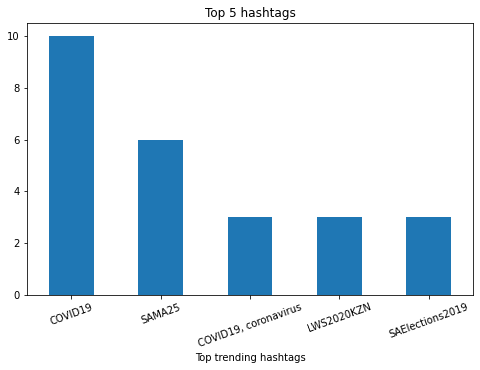

In [28]:
#Top trending hashtags and visualizing a bar graph

fig,ax=plt.subplots(figsize=(8,6))
plt.xlabel('Top trending hashtags')
plt.title('Top 5 hashtags')
df1['hashtags'].value_counts().head(5).plot(ax=ax,kind='bar',figsize=(8,5),rot=20)


In [29]:
print("Most used hashtags:")
for item, count in Counter(df1['hashtags']).most_common(6):
    print(str(item) + "\t" + str(count))

Most used hashtags:
nan	545
COVID19	10
SAMA25	6
LWS2020KZN	3
COVID19, coronavirus	3
BlackLivesMatter	3


In [ ]:
df1.grouby(['hashtags','user']).agg({'user':['count']})

#### Calculating the popularity score

In [31]:
##Some of my followers_count 
influencers_tweets['followers_count'].unique()

array(['10805650', '10805651', '10805652', '1974590', nan,
       'Zimbabwe, zimbabwecoup', '18', '3576997', '3576998', '3577036',
       '3576999', '3128318', '3128319', '3128320', '3128321', '1443331',
       '1443325', '1060210', '1164367', '1085212', '1085213', '200283',
       '1415934', '1415935', '1415936', '1415937', '1160175', '1042501',
       '1755121', '7', '183464', 'COVID19', '105676', '572326', '937983',
       '937984', '937985', '937986', '35229', '69', '49249', '541361',
       '541360', '56872', '673149', '673151', '673152', '114513',
       '151970', 'CSNkaissery', '51843', '29951', '59202', '59201',
       '220891', '220892', '215934', '130', '285568', '285571', '285569',
       '143194', '143198', '127359', 127359, 56246, 1076851, 1076852,
       1076853, 1076854, 1076855, 1076856, 1076860, 1076861, 84532, 88495,
       105656, 240572, 240573, 240574, 240575, 18630, 18631, 50083, 50084,
       48259, 48260, 1002718, 1002719, '1002719', 'JoburgIDP20', '165761',
   

In [33]:
influencers_tweets=influencers_tweets.loc[~influencers_tweets.followers_count.str.contains('Zimbabwe, zimbabwecoup',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.followers_count.str.contains('COVID19',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.followers_count.str.contains('CSNkaissery',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.followers_count.str.contains('JoburgIDP20',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.followers_count.str.contains('teachersmatter',na=False)]


In [34]:
influencers_tweets['followers_count'].dropna(inplace=True)
influencers_tweets['followers_count'].fillna(0,inplace=True)

In [35]:
influencers_tweets.head(10)

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,description,followers_count,friends_count,statuses_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,contains_sports
0,0,1282761976343662593,Mon Jul 13 19:41:02 +0000 2020,"<a href=""https://about.twitter.com/products/tw...",Actual video footage of me starting off the we...,Actual video footage starting week,"Sentiment(polarity=0.0, subjectivity=0.1)",0.000000,0.1,en,20826.0,2748.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY",False
1,1,1282073950843858944,Sat Jul 11 22:07:04 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @KingBach: https://t.co/Sj2sVP7Gdt,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,und,0.0,93038.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,KingBach,NaN,"New York, NY",NaN
2,2,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.050000,0.5,en,43410.0,6011.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY",False
3,3,1280258784485572611,Mon Jul 06 21:54:14 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Me at the restaurant after things return to no...,Me restaurant things return normal,"Sentiment(polarity=0.15, subjectivity=0.649999...",0.150000,0.6499999999999999,en,14700.0,1649.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,NaN,NaN,"New York, NY",False
4,4,1276561514456113152,Fri Jun 26 17:02:37 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @franklinleonard: “I have rape-colored skin...,I rape-colored skin,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,408.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,franklinleonard,NaN,"New York, NY",False
5,5,1276532276659175425,Fri Jun 26 15:06:26 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",There are people fighting to walk around a sup...,There people fighting walk around supermarket ...,"Sentiment(polarity=0.2857142857142857, subject...",0.285714,0.5357142857142857,en,34305.0,4987.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,NaN,NaN,NaN,NaN,"New York, NY",False
6,6,1276529543289942016,Fri Jun 26 14:55:34 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @SawyerHackett: Never would have thought a ...,Never would thought Tik Tok qualified immunity...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,56894.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,False,NaN,SawyerHackett,NaN,"New York, NY",False
7,7,1276300649630773253,Thu Jun 25 23:46:02 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",@kimlatricejones @DEADLINE 🙌🏽,NaN,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,und,60.0,4.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,NaN,NaN,"kimlatricejones, DEADLINE",NaN,"New York, NY",NaN
8,8,1276247505450270720,Thu Jun 25 20:14:51 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @Sensational_Dre: So a person with a felony...,So person felony cant vote still counted censu...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.0,en,0.0,102290.0,Trevornoah,Comedian from South Africa. I was in the crowd...,10805650,325,11185.0,NaN,NaN,Sensational_Dre,NaN,"New York, NY",False
9,9,1276197629794410498,Thu Jun 25 16:56:40 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @maleeezy_: a story in two parts: https://t...,story two parts,"Sentiment(po

In [36]:
influencers_tweets['Followers'] = influencers_tweets['followers_count'].apply(lambda x:int(x))

In [37]:
influencers_tweets.groupby(['original_author'])['Followers'].max()

original_author
14758.0                NaN
3118.0                 NaN
5FM              1164367.0
6476.0                 NaN
8771.0                 NaN
                   ...    
rangerdiaries      20452.0
savetherhino       80350.0
schneiderhome      26431.0
t_mcconnell        18501.0
willintune         18631.0
Name: Followers, Length: 78, dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

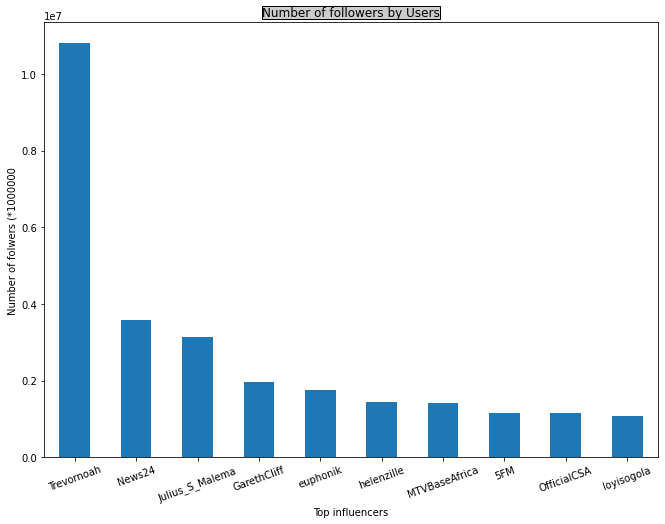

In [40]:
import matplotlib.pyplot as plot

followers_by_users = influencers_tweets.groupby(['original_author'])['Followers'].max().sort_values(ascending=False).head(10)
plt.title('Number of followers by Users', bbox={'facecolor':'0.8', 'pad':0})
followers_by_users.plot(kind='bar',figsize=(11, 8))
plt.ylabel('Number of folwers (*1000000')
plt.xlabel('Top influencers')
plt.xticks(rotation=20)

#### Calculating the reach score


In [48]:
##getting the number of people who they follow(friends_count)
influencers_tweets['friends_count'].unique()

array(['325', '356', nan, 'JayShantaram', '14', '631', '652', '2304',
       '478', '411', '3948', '1224', '109', '1999', '530321', '65', '0',
       '25601', 'AngieMurimirwa', '2987', '269', '1618', '455', '305',
       'khanyididi, gertjohan', '186', '985', '2204', '1641', '561',
       'InteriorKE', '987', 'outofthepickle', '480',
       'bj_pittman, kupandacapital, fsu', '3347', '11', '128', '141',
       '10833', '74077', '74076', '1545', 1545, 3166, 5473, 25645, 1940,
       391, 657, 1488, 757, 1114, 61972, 1144.0, 1009.0, 406.0, 4615.0,
       3706.0, 1346.0, 3122.0, 1905.0, 2051.0, 0.0, 983.0, 1979.0, '1979',
       '1920', '653',
       'BrianLinuxing, africagathering, FLOTUS, SarahBrownUK', '2415',
       '151', '49691', '1643', '220', '89607', '1155', '15', 15, 3604,
       940, 748, 814, 2256, 659], dtype=object)

In [49]:
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('khanyididi, gertjohan',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('bj_pittman, kupandacapital, fsu',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('BrianLinuxing, africagathering, FLOTUS, SarahBrownUK',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('outofthepickle',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('JayShantaram',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('AngieMurimirwa',na=False)]
influencers_tweets=influencers_tweets.loc[~influencers_tweets.friends_count.str.contains('InteriorKE',na=False)]

In [51]:
influencers_tweets['friends_count'].dropna(inplace=True)
influencers_tweets['friends_count'].fillna(0,inplace=True)

influencers_tweets['Following'] = influencers_tweets['friends_count'].apply(lambda x:int(x))

In [52]:
influencers_tweets.groupby(['original_author'])['Following'].max()

original_author
265258.0             NaN
5FM                411.0
8771.0               NaN
AfricaGoodNews     757.0
AfricaResearch    1940.0
                   ...  
rangerdiaries     4615.0
savetherhino       983.0
schneiderhome     1009.0
t_mcconnell        940.0
willintune        1488.0
Name: Following, Length: 76, dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

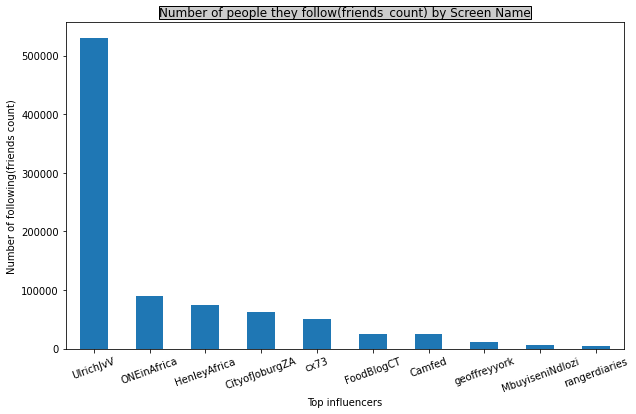

In [55]:
import matplotlib.pyplot as plot

followers_by_users = influencers_tweets.groupby(['original_author'])['Following'].max().sort_values(ascending=False).head(10)
plt.title('Number of people they follow(friends_count) by Screen Name', bbox={'facecolor':'0.8', 'pad':0})
followers_by_users.plot(kind='bar',figsize=(10, 6))
plt.ylabel('Number of following(friends count)')
plt.xlabel('Top influencers')
plt.xticks(rotation=20)

In [56]:
reach_score= influencers_tweets.groupby(['original_author'])['friends_count', 'followers_count'].max().reset_index()
reach_score['reach_score']=reach_score['friends_count']+reach_score['followers_count']
reach_score_sorted=reach_score.sort_values(by='reach_score',ascending=False)[0:11].reset_index(drop=True)
reach_score_sorted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,original_author,friends_count,followers_count,reach_score
0,Trevornoah,325.0,1.08057e+07,1.0806e+07
1,News24,631.0,3.57704e+06,3.57767e+06
2,Julius_S_Malema,652.0,3.12832e+06,3.12897e+06
3,GarethCliff,356.0,1.97459e+06,1.97495e+06
4,euphonik,65.0,1.75512e+06,1.75519e+06
5,UlrichJvV,530321.0,1.0425e+06,1.57282e+06
6,helenzille,2304.0,1.44333e+06,1.44564e+06
7,MTVBaseAfrica,109.0,1.41594e+06,1.41605e+06
8,5FM,411.0,1.16437e+06,1.16478e+06
9,OfficialCSA,1999.0,1.16018e+06,1.16217e+06


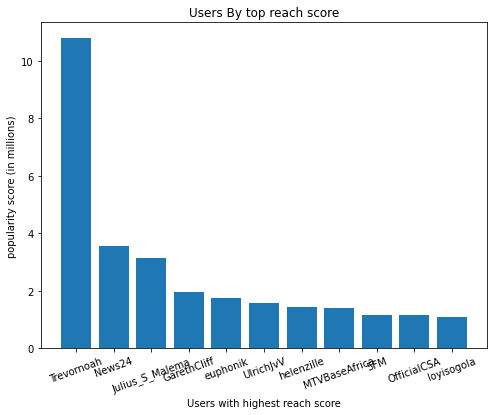

In [86]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax=plt.subplots(figsize=(8,6))

x=np.arange(0,11)
y=reach_score_sorted['reach_score']/1000000

my_xticks=reach_score_sorted['original_author']


plt.xticks(x,my_xticks,rotation=20)
plt.xlabel('Users with highest reach score')
plt.ylabel('popularity score (in millions)')
plt.title('Users By top reach score')
ax.bar(x,y)
#plt.grid()
plt.show()

In [61]:
influencers_tweets.groupby(['original_author'])['statuses_count'].max()

original_author
265258.0              NaN
5FM               62839.0
8771.0                NaN
AfricaGoodNews    11100.0
AfricaResearch    23204.0
                   ...   
rangerdiaries      3906.0
savetherhino      35782.0
schneiderhome     32731.0
t_mcconnell       15627.0
willintune         8548.0
Name: statuses_count, Length: 76, dtype: float64

In [62]:
likes=influencers_tweets.groupby(['original_author'])['favorite_count'].sum().sort_values(ascending=False).reset_index()
#likes.plot(kind='bar')
likes.head(5)

,original_author,favorite_count
0,Trevornoah,8116185.0
1,265258.0,2005438.0
2,Julius_S_Malema,1229486.0
3,MbuyiseniNdlozi,1171031.0
4,UlrichJvV,752883.0


In [63]:
retweets=influencers_tweets.groupby(['original_author'])['retweet_count'].sum().sort_values(ascending=False).reset_index()
#retweets.plot(kind='bar')
retweets.head(5)

,original_author,retweet_count
0,Trevornoah,18506676.0
1,MbuyiseniNdlozi,8806356.0
2,Julius_S_Malema,5302814.0
3,AfricaGoodNews,4573300.0
4,BobSkinstad,3807328.0


In [75]:
pop_score= influencers_tweets.groupby(['original_author'])["retweet_count", "favorite_count"].sum().reset_index()
pop_score['popularity_score']=pop_score['retweet_count']+pop_score['favorite_count']
pop_score_sorted=pop_score.sort_values(by='popularity_score',ascending=False)[0:8].reset_index(drop=True)
pop_score_sorted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,original_author,retweet_count,favorite_count,popularity_score
0,Trevornoah,18506676.0,8116185.0,26622861.0
1,MbuyiseniNdlozi,8806356.0,1171031.0,9977387.0
2,Julius_S_Malema,5302814.0,1229486.0,6532300.0
3,AfricaGoodNews,4573300.0,2532.0,4575832.0
4,BobSkinstad,3807328.0,9719.0,3817047.0
5,JendayiFrazer,3601811.0,1298.0,3603109.0
6,mikestopforth,2562507.0,17402.0,2579909.0
7,iamsuede,2190905.0,5211.0,2196116.0


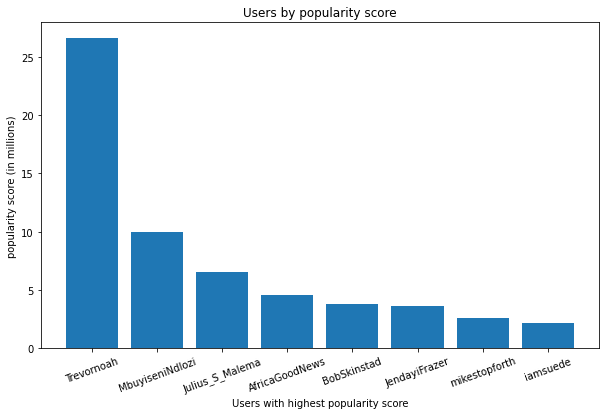

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax=plt.subplots(figsize=(10,6))

x=np.arange(0,8)
y=pop_score_sorted['popularity_score']/1000000

my_xticks=pop_score_sorted['original_author']

plt.xticks(x,my_xticks,rotation=20)
plt.xlabel('Users with highest popularity score')
plt.ylabel('popularity score (in millions)')
plt.title('Users by popularity score')
ax.bar(x,y)
#plt.grid()
plt.show()

### Calculating the relevance score by mentions

In [77]:
mentions=influencers_tweets.groupby(['original_author'])['user_mentions']

In [78]:
mentions.head(5)

0                             NaN
1                        KingBach
2                             NaN
3                             NaN
4                 franklinleonard
                   ...           
214787                        NaN
214788    Channel4News, decappeal
214789                        NaN
214790                        NaN
214791                        NaN
Name: user_mentions, Length: 374, dtype: object

In [79]:

influencers_tweets['user_mentions'].dropna(inplace=True)
influencers_tweets['user_mentions'].fillna(0,inplace=True)

In [80]:
###Getting the number of mentions of each user
mentions_dict={}
for mention in influencers_tweets['user_mentions']:
  for singlemention in (mention.split(',')):
    authors=influencers_tweets['original_author'].unique().tolist()
    if singlemention in authors:
      if singlemention not in mentions_dict.keys():
          mentions_dict[singlemention]=1
      else:
          mentions_dict[singlemention]=mentions_dict[singlemention] +1

In [81]:
mentions_dict

{'5FM': 22,
 'AfricaGoodNews': 43,
 'AfricaResearch': 158,
 'Aynte': 22,
 'BobSkinstad': 12,
 'Camfed': 17,
 'CityofJoburgZA': 197,
 'Computicket': 4,
 'Entrepreneur_SA': 2,
 'GarethCliff': 40,
 'GautengProvince': 62,
 'Hamza_Africa': 93,
 'HenleyAfrica': 55,
 'IECSouthAfrica': 9,
 'IFCAfrica': 62,
 'JamalMOsman': 66,
 'JendayiFrazer': 14,
 'Julius_S_Malema': 73,
 'MTVBaseAfrica': 54,
 'MadeItInAfrica': 18,
 'MbuyiseniNdlozi': 106,
 'MercedesBenz_SA': 9,
 'Mo_IbrahimFdn': 153,
 'NDOCKenya': 8,
 'News24': 315,
 'ONEinAfrica': 168,
 'OfficialCSA': 1,
 'OkayAfrica': 385,
 'ParliamentofRSA': 53,
 'PeterGreste': 16,
 'SAPresident': 1,
 'SamsungSA': 4,
 'SandtonCity': 29,
 'SmithInAfrica': 4,
 'TheAfricaReport': 132,
 'TheStar_news': 31,
 'ThinkAfricaFeed': 12,
 'Trevornoah': 35,
 'UlrichJvV': 676,
 '_AfricanUnion': 420,
 'africagathering': 35,
 'africaprogress': 326,
 'africatechie': 70,
 'art2gee': 27,
 'audisouthafrica': 22,
 'ayittey': 13,
 'cnbcafrica': 499,
 'cx73': 6,
 'daniel_howden'

In [82]:
relevance_score=pd.DataFrame(mentions_dict.items(),columns=['original_authors','num_mentions'])
relevance_score.sort_values(by='num_mentions',ascending=False).head(15).reset_index(drop=True)

,original_authors,num_mentions
0,UlrichJvV,676
1,cnbcafrica,499
2,_AfricanUnion,420
3,OkayAfrica,385
4,africaprogress,326
5,News24,315
6,pressfreedom,295
7,CityofJoburgZA,197
8,ONEinAfrica,168
9,AfricaResearch,158


In [83]:
##create an ordered list of tuples with the most mentioned users and the number of times they have been mentioned

mentions_ordered_list=sorted(mentions_dict.items(),key=lambda x:x[1])
mentions_ordered_list=mentions_ordered_list[::-1]


##pick top 20 mentioned users to plot and seperate the previous list into two lists:one with users and the other with values:
mentions_ordered_values=[]
mentions_ordered_keys=[]
for item in mentions_ordered_list[0:20]:
  mentions_ordered_keys.append(item[0])
  mentions_ordered_values.append(item[1])
  


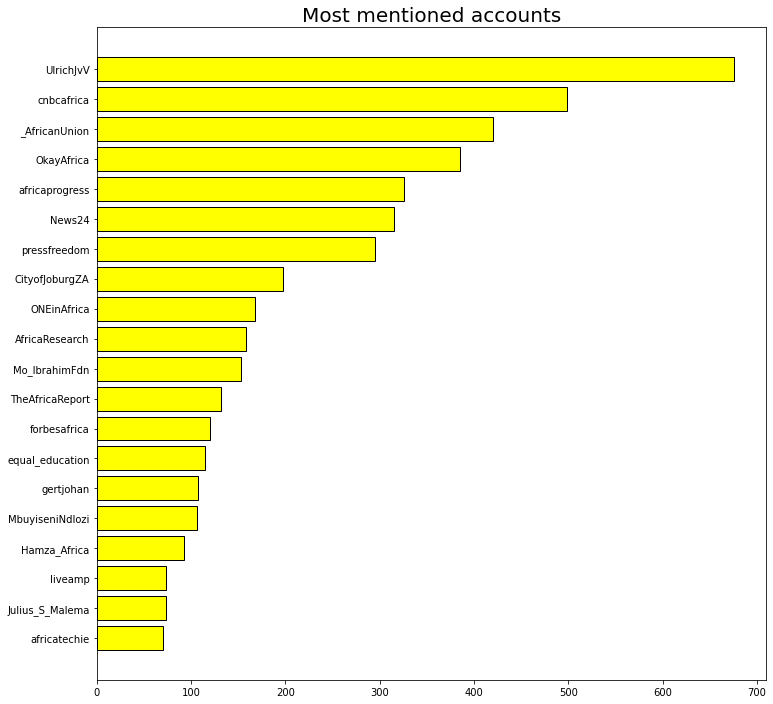

In [84]:
#plot
import numpy as np 

fig,ax=plt.subplots(figsize=(12,12))
y_pos=np.arange(len(mentions_ordered_values))
ax.barh(y_pos,list(mentions_ordered_values)[::-1],align='center',color='yellow',edgecolor='black',linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_title('Most mentioned accounts',fontsize=20)
plt.show()

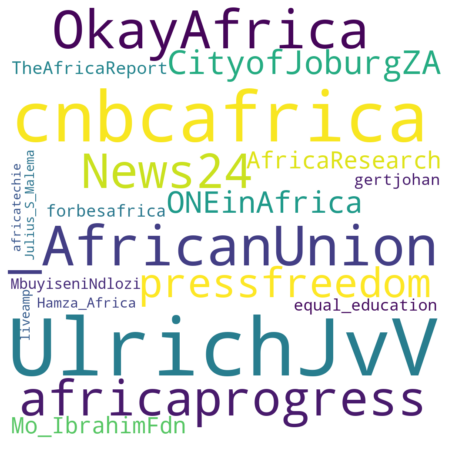

In [85]:
##word cloud
from wordcloud import WordCloud
mentions_ordered_dict={}
for item in mentions_ordered_list[0:20]:
  mentions_ordered_dict[item[0]]=item[1]
wordcloud=WordCloud(width=1000,height=1000,random_state=21,max_font_size=200,background_color='white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

plt.show()

### Search twitter and fetch data example

In [ ]:
covid_keywords = '#Ethiopia'  #hashtag based search
tweets_file = 'data/ethiopia_3july2020.json'


##get data on keywords
if os.path.exists(tweets_file):
    #get file if you have already downloaded what you wanted
    df = pd.read_csv(tweets_file, header=0)
    if 'timestamp' in df.columns:
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)    
else:
    ts = tweetsearch()
    df = ts.get_tweets(covid_keywords, csvfile=tweets_file)    #you saved the 

In [ ]:
#df = df.set_index('timestamp')

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36791 entries, 2020-06-25 14:28:48+00:00 to 2020-07-04 07:47:03+00:00
Data columns (total 16 columns):
created_at                36791 non-null object
source                    36788 non-null object
original_text             36791 non-null object
clean_text                33708 non-null object
sentiment                 36791 non-null object
polarity                  36791 non-null float64
subjectivity              36791 non-null float64
lang                      36791 non-null object
favorite_count            36791 non-null int64
retweet_count             36791 non-null int64
original_author           36791 non-null object
possibly_sensitive        10561 non-null object
hashtags                  32042 non-null object
user_mentions             29412 non-null object
place                     220 non-null object
place_coord_boundaries    23002 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 4.8+ MB


In [ ]:
df.groupby('hashtags').source.count()

hashtags
0dam, Ethiopia, Egypt                                                                                                                                                                                               1
100days, Ethiopia, awakening, pandemic, LosAngelesProtest                                                                                                                                                           1
100days, headshot, COVID19, ChineseAppsBlocked, TuesdayMotivation, tuesdayvibes, tiktokbanindia, Ethiopia                                                                                                           1
10k, again, morningrun, uraelchurch, leipzigsquare, PMoffice, piazza, churchillroad, meskelsquare, sightseeing, addisababa, mycity, ethiopia, landoforigins, seeyousoon                                             1
10yrPlanEthiopia, Ethiopia                                                                                                             

Text(0, 0.5, 'Number of Tweets')

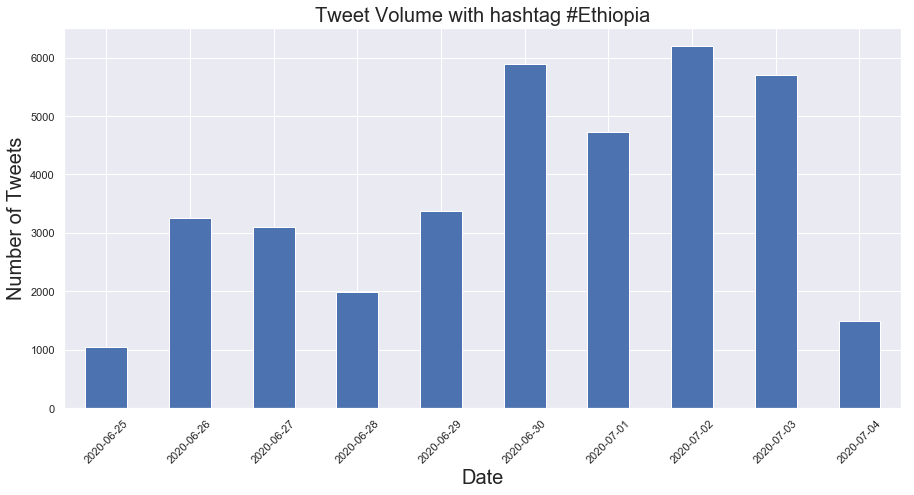

In [ ]:
#plot data
#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet Volume with hashtag #Ethiopia', fontsize=20)
df.groupby(df.index.map(lambda x:x.date())).source.count().plot.bar(rot=45)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

# fig, ax = plt.subplots(figsize=(15,7))
# ax.set_title('Tweet Volume', fontsize=20)
# df.groupby('hashtags').source.count().plot.bar(rot=45)
# #set major ticks format
# #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# ax.set_xlabel('Hashtags', fontsize=20)
# ax.set_ylabel('Number of Tweets', fontsize=20)

Text(0, 0.5, 'Sentiment Score')

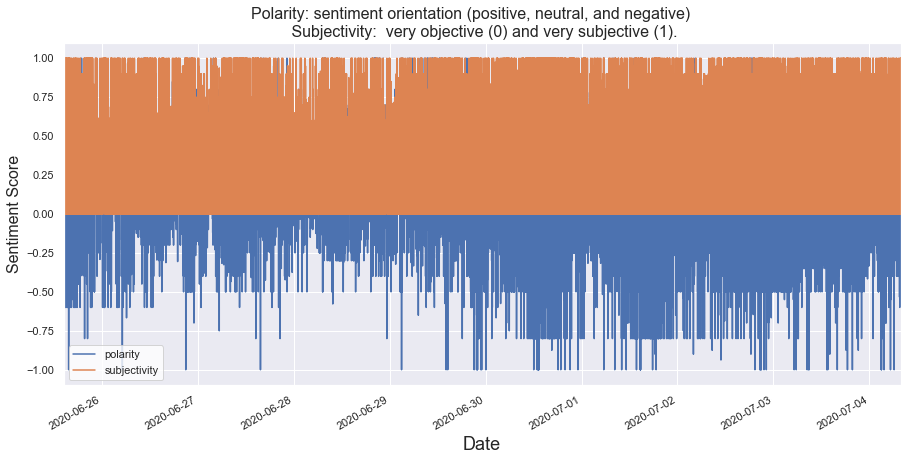

In [ ]:
#df.info()
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Polarity: sentiment orientation (positive, neutral, and negative) \
    \n Subjectivity:  very objective (0) and very subjective (1).', fontsize=16)
with sns.axes_style("whitegrid"):
    df[['polarity','subjectivity']].plot(ax=ax)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Sentiment Score', fontsize=16)

Text(0, 0.5, 'Number of Tweets')

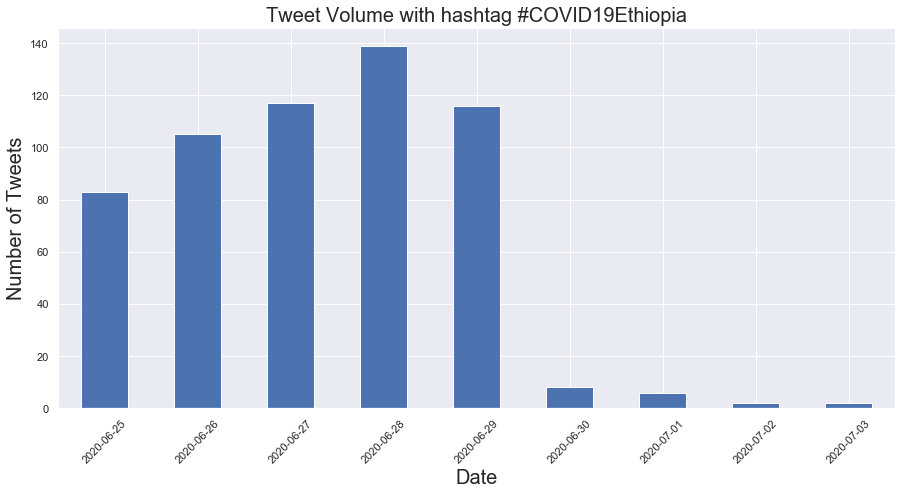

In [ ]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet Volume with hashtag #COVID19Ethiopia', fontsize=20)
df.groupby(df.index.map(lambda x:x.date())).source.count().plot.bar(rot=45)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

In [ ]:
print_full(df['original_text'].unique())

['How can farmers in Ethiopia work safe and smart during COVID-19 lockdown? - @IIED | #Ethiopia #COVID19Ethiopia | https://t.co/nAYUhFonVO'
 "The last report on #COVID19Ethiopia by the Health Ministry of Ethiopia🇪🇹was on June 29th. \n\nIt's due to the break out of protests in several towns across #Ethiopia after the killing of #HachaluHundessa, a popular Oromo singer. Internet services is also shutdown across the country https://t.co/crbMs7rY6p"
 '#COVID19Ethiopia updates https://t.co/riKf2nBqo4'
 'RT @amggebre: Please STOP inciting the youth to carry out violent acts! That is a cardinal sin! An insane act that will harm the youth!\n#Et…'
 'Please STOP inciting the youth to carry out violent acts! That is a cardinal sin! An insane act that will harm the youth!\n#Ethiopia needs peace and calm to fight #covid19ethiopia https://t.co/bJiy5yDxuF'
 '@France24_en Condolences #SafetyFirst #PysicalDistancing  bitter though,there shall be time to react appropriately for positive change once Air 

## Stream data and save it to file
In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

### **SAME TASK AS ABOVE**


In [ ]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='data/tweets.json',
                      keywords=['COVID19KE'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('Tweet Keywords are: ',keywords)
    print('For testing case, please interupt the downloading process \
            using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
    

    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None



### Use case of the above code

In [ ]:
tweets_file = 'data/covid19_1july2020.json'
stream_tweet_data(filename=tweets_file,keywords=['covid19'])  

### Filter twitter data and do basic analysis
**Extend it to gain more insight**

In [ ]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweets_data))

saved numbers of tweets:  1000


In [ ]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] \
                             if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()
tweets_by_lang

In [ ]:
tweets_by_country = tweets['country'].value_counts()
tweets_by_country

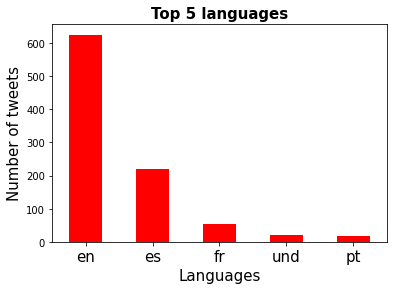

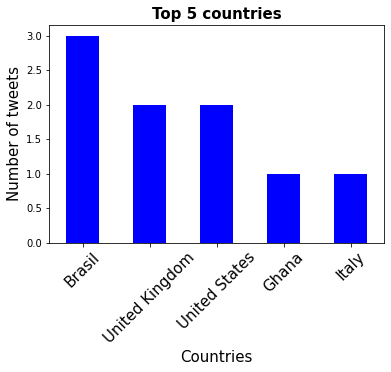

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red', rot=0)

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue', rot=45)

# Hashtag histogram. 

## Please write code that will help you answer the following questions
 1) What is the most used hashtag?

 2) What is the most used referenced username?

 3) What is the most retweeted tweet?